In [1]:
%matplotlib notebook

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import mpld3
#import matplotlib.pyplot as plt
mpld3.enable_notebook()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob # for parsing a folder
from scipy.optimize import curve_fit
import random
import json
import os

In [4]:
np.set_printoptions(linewidth=120)
plt.rcParams["figure.figsize"] = (12.0,8.0)
plt.rcParams["legend.loc"] = "lower right"

In [3]:
base_path = "PASS TO EENGINE ROOT DIRECTORY"
experiment_folder = base_path + 'data/thermal-sc_augmentation_parameters'

In [4]:
# parsing all folders and storing locations of log files
AMBIENTS = np.arange(5,55,5)
RUN_STRINGS = ['435', '495']
PHONE_NAMES = ['Z5', 'S5']
LOG_NAME = '000_snk.log.csv'

BILBO_SENSOR_NORMALIZATION_FACTOR = {'thermal_sysfs:zone:0:°C': 100000,\
                                     'thermal_sysfs:zone:1:°C': 100000,\
                                     'thermal_sysfs:zone:14:°C': 10,\
                                     'thermal_sysfs:zone:15:°C': 10,\
                                     'thermal_sysfs:zone:18:°C':10,\
                                     'thermal_sysfs:zone:23:°C':10}

FRODO_SENSOR_NORMALIZATION_FACTOR = {'thermal_sysfs:zone:1:°C': 100000}

TIMESTAMP_COLUMN = 'host:timestamp::ns'

COOL_TIME = {'435': (80, 275), '495': (130,340)}


data = [{'ambient': int(a), 'phone' : pn, 'run' : int(r), 'file':experiment_folder + 'tcoeff_'+ '{0:0=2d}'.format(a) + '-%s/%s/%s'%(r,pn,LOG_NAME)} \
                for pn in PHONE_NAMES \
                for r in RUN_STRINGS \
                for a in AMBIENTS] 

# dataframe 10 is problematic. Manually removing it
data = data[0:10] + data[11:]

In [13]:
# now reading all thermal logs
for i,d in enumerate(data):
    d['log'] = pd.read_csv(d['file'], sep=',')
    thermal_bool = [c.startswith('thermal') for c in d['log'].columns]
    columns_to_keep = np.insert(d['log'].columns[thermal_bool], 0, TIMESTAMP_COLUMN)
    d['tzones'] = d['log'].columns[thermal_bool]
    d['log'] = d['log'][columns_to_keep]
    d['log'][TIMESTAMP_COLUMN] = (d['log'][TIMESTAMP_COLUMN] - d['log'][TIMESTAMP_COLUMN].iloc[0])/1e9
    # normalizing temperature values for bilbo
    if d['phone'] == 'Z5':
        for k,v in BILBO_SENSOR_NORMALIZATION_FACTOR.items():
            d['log'][[k]] = d['log'][[k]] / v 
    # normalizing temperature values for frodo
    if d['phone'] == 'S5':
        for k,v in FRODO_SENSOR_NORMALIZATION_FACTOR.items():
            d['log'][[k]] = d['log'][[k]] / v 
    
    # truncating trace to only include the cooling part. also converting to seconds
    start, end = COOL_TIME[str(d['run'])]
    d['log'] = d['log'][(d['log'][TIMESTAMP_COLUMN]>start) & (d['log'][TIMESTAMP_COLUMN]<end)] 
    d['log'][TIMESTAMP_COLUMN] = d['log'][TIMESTAMP_COLUMN] - d['log'][TIMESTAMP_COLUMN].iloc[0]
    #d['log2'] = d['log'][['thermal_sysfs:zone:26:°C', 'thermal_sysfs:zone:30:°C']]


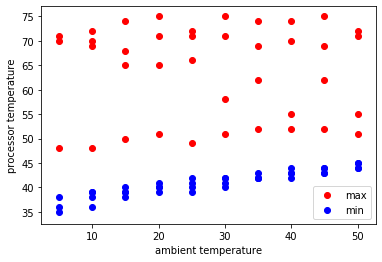

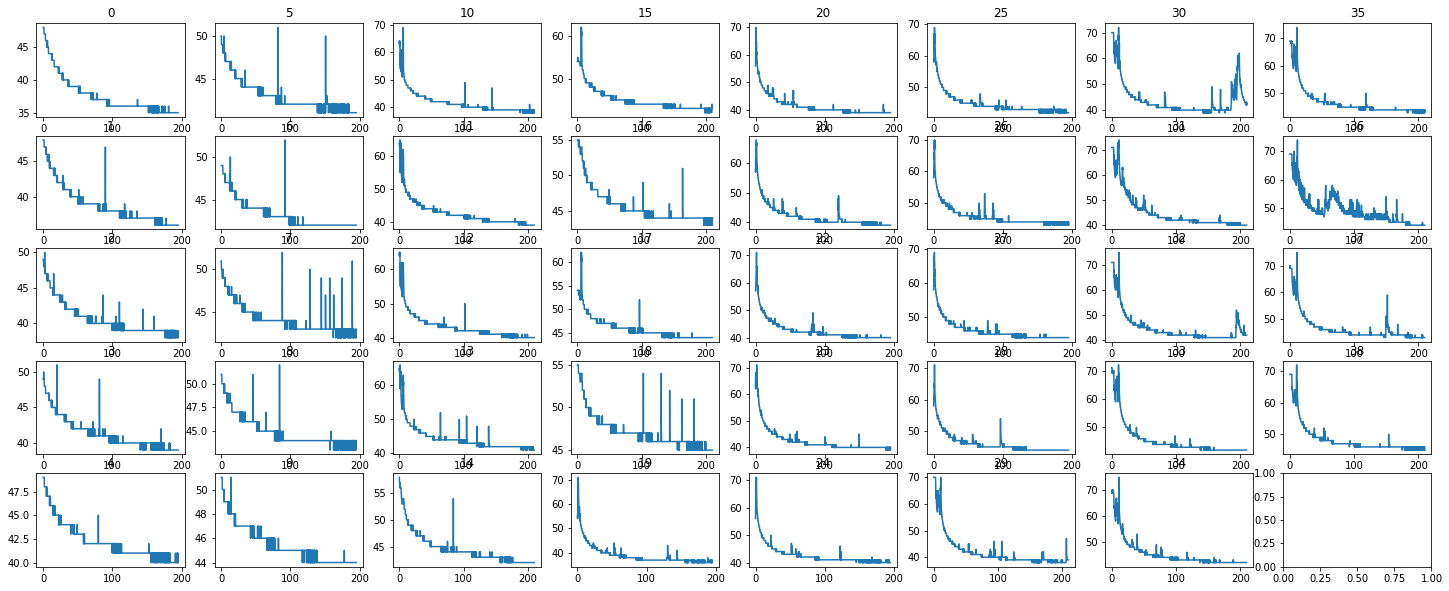

In [14]:
# ambient condition is not corretly emulated. Verifying this...

thermal_zone = {'Z5': 'thermal_sysfs:zone:9:°C',\
               'S5': 'thermal_sysfs:zone:0:°C'} # chosen these since this seems to have the higher temperature

maxtemp, mintemp, ambient = [],[],[]
for d in data:
    df = d['log'][thermal_zone[d['phone']]]
    maxtemp.append(df.max())
    mintemp.append(df.min())
    ambient.append(d['ambient'])
    
plt.figure()
plt.scatter(ambient, maxtemp, label='max', color='red')
plt.scatter(ambient, mintemp, label='min', color='blue')
plt.ylabel('processor temperature')
plt.xlabel('ambient temperature')
plt.legend()

# will approximate the final temperature as the ambient. 

nr, nc = 5, 8
fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize =(25,10))
for i,dat in enumerate(data):
    temperature = dat['log'][thermal_zone[dat['phone']]].values
    time = dat['log'][TIMESTAMP_COLUMN].values
    row, column = i% nr, i//nr
    axes[row][column].plot(time, temperature)
    axes[row][column].set_title(str(i))



In [5]:
#computing optimal cooling copefficients for each thermal zone and each experiment

for d in data:
    timestamps = d['log'][TIMESTAMP_COLUMN].values
    d['beta'] = {}
    for tz in d['tzones']:
        trace = d['log'][tz].values
        init, final = max(trace), min(trace)
        opt_param = curve_fit(lambda t,b: (init-final)*np.exp(-1* b * t) + final,  timestamps,  trace)
        d['beta'][tz] = opt_param


/home/rahmed/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [6]:
# computing consolidated thermal coefficients

betas_matrix = {p:{} for p in PHONE_NAMES}

for d in data:
    if not(betas_matrix[d['phone']]): 
            betas_matrix[d['phone']] = {tz:[] for tz in d['tzones']}
    for tz in d['tzones']:
        betas_matrix[d['phone']][tz].append(d['beta'][tz][0][0])


def average_reject_outliers(data, m=2):
    data = np.array(data)
    mean, tol = np.mean(data), m * np.std(data)
    return np.average(data[abs(data - mean) < tol])

betas = {}
betas[PHONE_NAMES[0]] = {k: average_reject_outliers(v) for k,v in betas_matrix[PHONE_NAMES[0]].items()}
betas[PHONE_NAMES[1]] = {k: average_reject_outliers(v) for k,v in betas_matrix[PHONE_NAMES[1]].items()}

# writing dictionary to a text file in json format
with open('thermal_coefficients', 'w') as file:
     file.write(json.dumps(betas)) # use `json.loads` to do the reverse


#print("Z5 Betas\n", betas[PHONE_NAMES[0]], '\n\n', "S5 Betas\n", betas[PHONE_NAMES[1]])         

/home/rahmed/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/rahmed/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


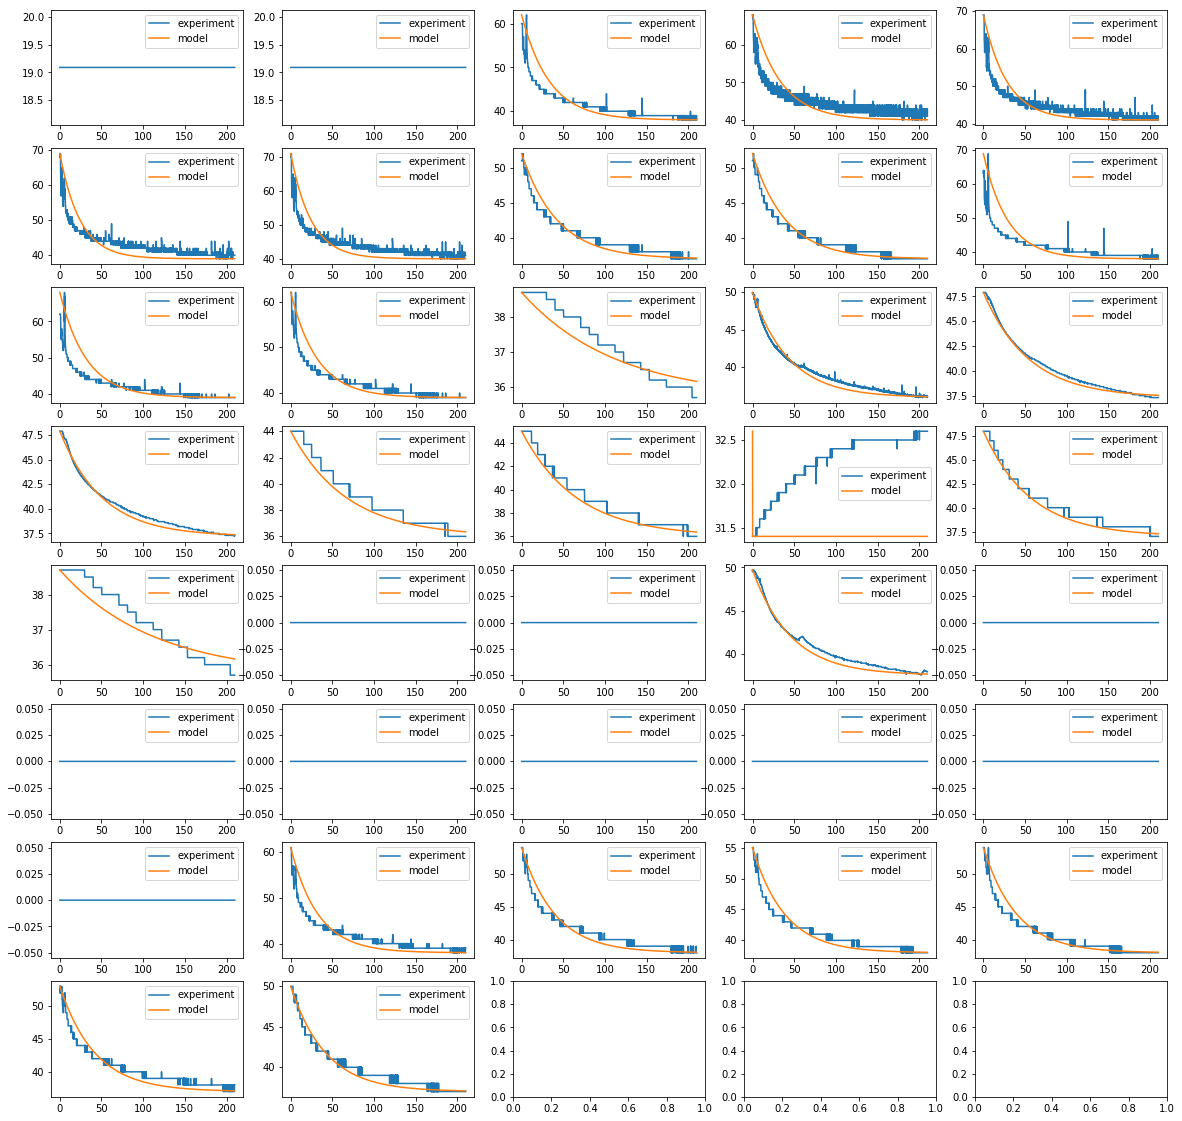

In [7]:
# now checking the validity of the thermal model

def compute_temperature(initial, ambient, timestamps, coefficient):
    return (initial - ambient) * np.exp(-1 * coefficient * timestamps) + ambient


experiment = data[10] # change 10 to any index in interval [0, 39]


be = betas[experiment['phone']]
timestamps = experiment['log'][TIMESTAMP_COLUMN].values

ncols = 5
nrows = np.ceil(len(experiment['tzones'])/5).astype(int)
figure, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize = (20,20))
for i,tz in enumerate(experiment['tzones']):
    r,c = i//ncols, i%ncols
    trace = experiment['log'][tz].values
    initial, ambient = max(trace), min(trace)
    b = be[tz]
    model_temperature = compute_temperature(initial, ambient, timestamps, b)
    if experiment['phone'] == PHONE_NAMES[0]:
        axes[r][c].plot(timestamps, trace, label='experiment')
        axes[r][c].plot(timestamps, model_temperature, label='model')
        axes[r][c].legend()
    else:
        axes[c].plot(timestamps, trace, label='experiment')
        axes[c].plot(timestamps, model_temperature, label='model') 
        axes[c].legend()
    

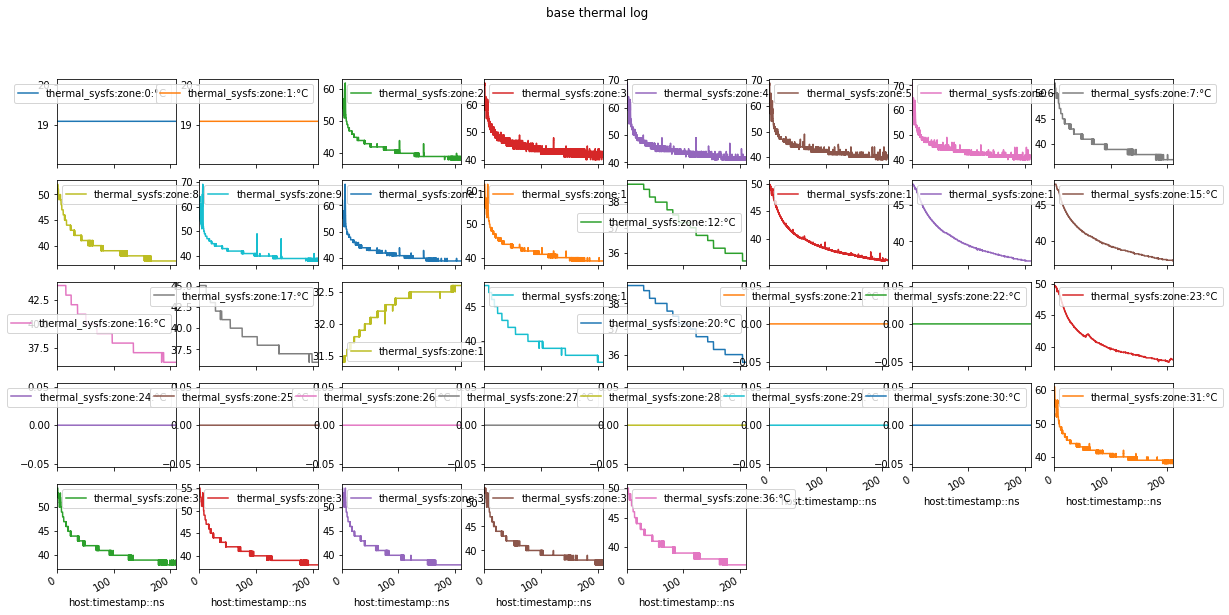

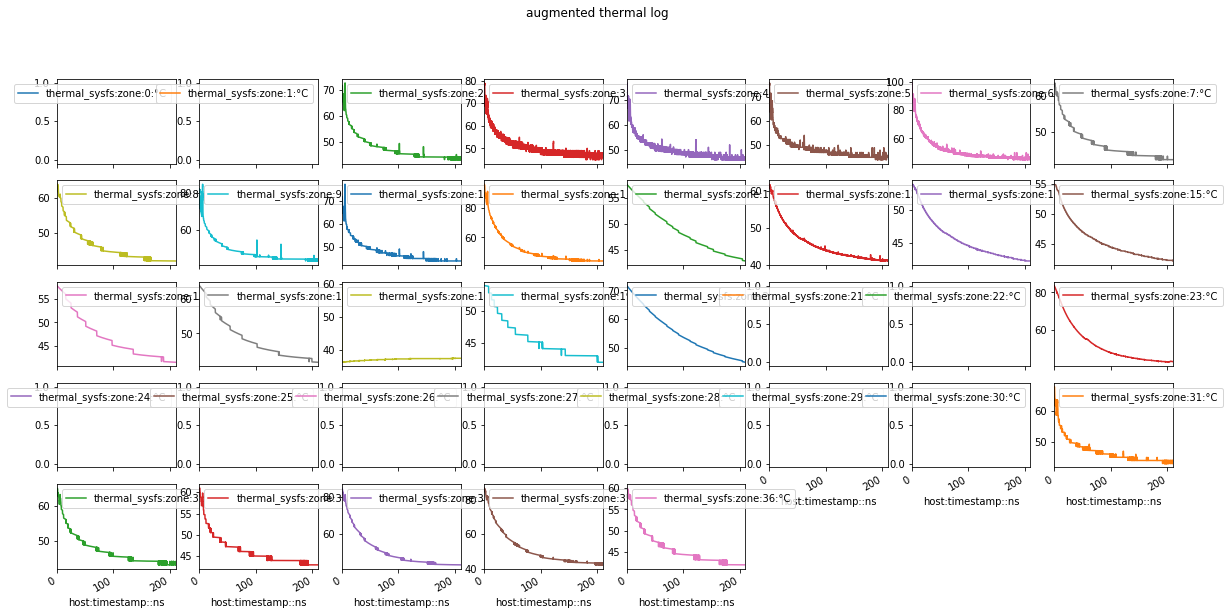

In [8]:
# now augmenting a given trace

def augment_log(base_log, dynamic_offsets, ambient_offset, coefficients):
    headers = coefficients.keys()
    timestamps = base_log.index
    augment_component = {head: compute_temperature(dynamic_offsets[head] + ambient_offset, ambient_offset, timestamps, coefficients[head]) for head in headers}
    augment_df = pd.DataFrame.from_dict(augment_component)
    augment_df.index = timestamps 
    final_thermal_log = base_log + augment_df
    return final_thermal_log

experiment = data[10]

base_log = experiment['log'].set_index(TIMESTAMP_COLUMN) # setting index as time for column wise augmentation
phone = experiment['phone']
coefficients = betas[phone]

thermal_zones = [c for c in base_log.columns if c.startswith('thermal')]

dynamic_offset_choices = np.arange(0,30, 1)
dynamic_offsets = {tz:random.choice(dynamic_offset_choices) for tz in thermal_zones}

ambient_offset= 5


augmented_log = augment_log(base_log, dynamic_offsets, ambient_offset, coefficients)

base_log.plot(title='base thermal log', subplots=True, layout=(5,8), figsize=(20,10));
augmented_log.plot(title='augmented thermal log', subplots=True, layout=(5,8), figsize=(20,10));
    
    

-------------------------- Z5 -------------------------------
thermal_sysfs:zone:0:°C : 38.9506575
thermal_sysfs:zone:1:°C : 38.9506575
thermal_sysfs:zone:2:°C : 29.0
thermal_sysfs:zone:3:°C : 32.0
thermal_sysfs:zone:4:°C : 32.0
thermal_sysfs:zone:5:°C : 31.0
thermal_sysfs:zone:6:°C : 31.0
thermal_sysfs:zone:7:°C : 28.0
thermal_sysfs:zone:8:°C : 27.0
thermal_sysfs:zone:9:°C : 29.0
thermal_sysfs:zone:10:°C : 29.0
thermal_sysfs:zone:11:°C : 29.0
thermal_sysfs:zone:12:°C : 25.0
thermal_sysfs:zone:13:°C : 26.695
thermal_sysfs:zone:14:°C : 27.5
thermal_sysfs:zone:15:°C : 27.5
thermal_sysfs:zone:16:°C : 26.0
thermal_sysfs:zone:17:°C : 26.0
thermal_sysfs:zone:18:°C : 24.4
thermal_sysfs:zone:19:°C : 28.0
thermal_sysfs:zone:20:°C : 25.0
thermal_sysfs:zone:21:°C : 0.0
thermal_sysfs:zone:22:°C : 0.0
thermal_sysfs:zone:23:°C : 28.7
thermal_sysfs:zone:24:°C : 0.0
thermal_sysfs:zone:25:°C : 0.0
thermal_sysfs:zone:26:°C : 0.0
thermal_sysfs:zone:27:°C : 0.0
thermal_sysfs:zone:28:°C : 0.0
thermal_sysfs

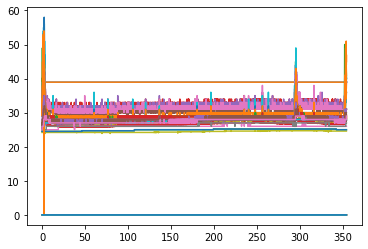

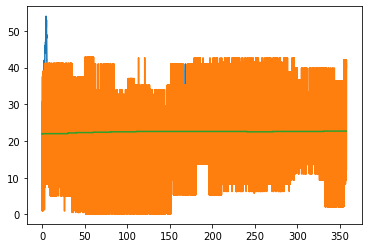

In [27]:
T_idle_run = experiment_folder + 'tidle_22-495/'
PHONE_NAMES = ['S5', 'Z5']
LOG_NAME = '000_snk.log.csv'
meas = dict()

for env in PHONE_NAMES:
    meas[env] = dict()
    meas[env]['data']= pd.read_csv(T_idle_run + env + '/' + LOG_NAME, sep=',')
    thermal_bool = [c.startswith('thermal') for c in meas[env]['data'].columns]
    columns_to_keep = np.insert(meas[env]['data'].columns[thermal_bool], 0, TIMESTAMP_COLUMN)
    meas[env]['tzones'] = meas[env]['data'].columns[thermal_bool]
    meas[env]['data'] = meas[env]['data'][columns_to_keep]
    meas[env]['data'][TIMESTAMP_COLUMN] = (meas[env]['data'][TIMESTAMP_COLUMN] - meas[env]['data'][TIMESTAMP_COLUMN].iloc[0])/1e9
    # normalizing temperature values for bilbo
    if env == 'Z5':
        for k,v in BILBO_SENSOR_NORMALIZATION_FACTOR.items():
            meas[env]['data'][[k]] = meas[env]['data'][[k]] / v 
    # normalizing temperature values for frodo
    if env == 'S5':
        for k,v in FRODO_SENSOR_NORMALIZATION_FACTOR.items():
            meas[env]['data'][[k]] = meas[env]['data'][[k]] / v 
            
    meas[env]['T_idle'] = dict()
    print("-------------------------- " + env + " -------------------------------")
    for column in meas[env]['data'].columns[1:]:
        meas[env]['T_idle'][column] = meas[env]['data'][column].median()
        print(column, ':', meas[env]['T_idle'][column])
    
    plt.figure()
    plt.plot(meas[env]['data'][TIMESTAMP_COLUMN], meas[env]['data'].iloc[:,1:])
    

# T_env for S5 and Z5

In [ ]:
from scipy.signal import medfilt
import toml
def compute_temperature(initial, ambient, timestamps, coefficient):
    return (initial - ambient) * np.exp(-1 * coefficient * timestamps) + ambient

beta = {}
base_path = '/home/miedlp/Documents/workspace/toolkit/datapro/data/CONVERT_Thermal-SC_thermal_parameters'
run_name  = 'tenv_00-000'
#env       = 'Z5'  # CPUs only T_zones: [2,3,4,5,6,9,10,11]
env       = 'S5'  # CPUs only T_zones: [0]
log_name = '000_snk.log.csv'

col_timestamps = 'host:timestamp::ns'

for env in ['S5', 'Z5']:
    read_path = base_path + '/' + run_name + '/' + env + '/' + log_name
    
    data = pd.read_csv(read_path, sep=',')
    
    
    
    if env is 'Z5':
        start = {
                  'down':np.where(data[col_timestamps] >= 21400000000000)[0][0],
                  'up':np.where(data[col_timestamps] >= 24500000000000)[0][0]
                }
        end   = {
                  'down':np.where(data[col_timestamps] >= 23400000000000)[0][0],
                  'up':np.where(data[col_timestamps] <= 34000000000000)[0][-1]
                }
        zone  = 'thermal_sysfs:zone:2:°C'
    elif env is 'S5':
        start = {
                  'down':np.where(data[col_timestamps] >= 12300000000000)[0][0],
                  'up':np.where(data[col_timestamps] >= 13000000000000)[0][0]
                }
        end   = {
                  'down':np.where(data[col_timestamps] >= 13000000000000)[0][0],
                  'up':np.where(data[col_timestamps] <= 17300000000000)[0][-1]
                }

        zone  = 'thermal_sysfs:zone:0:°C'
    beta[env] = {'up': {}, 'down':{}}
    for direction in ['up', 'down']:
        timestamps      = ((data[col_timestamps].iloc[start[direction]:end[direction]] - data[col_timestamps].iloc[start[direction]]) / 10**9).to_numpy()
        for zone in data.columns:
            if 'thermal' in zone:
                trace           = data[zone].iloc[start[direction]:end[direction]].to_numpy()
                trace           = medfilt(data[zone].iloc[start[direction]:end[direction]].to_numpy(), 25)
                if direction is 'up':
                    init, final     = trace.min(), trace.max()
                else:
                    init, final     = trace.max(), trace.min()
                tmp = curve_fit(lambda t,b: (init-final)*np.exp(-1* b * t) + final,  timestamps,  trace)
                beta[env][direction][zone] = tmp[0]
                

In [106]:
print(toml.dumps(beta))

[Z5.up]
"thermal_sysfs:zone:0:°C" = [ "1.0",]
"thermal_sysfs:zone:1:°C" = [ "1.0",]
"thermal_sysfs:zone:2:°C" = [ "0.0008290660160684118",]
"thermal_sysfs:zone:3:°C" = [ "0.0006078324535179333",]
"thermal_sysfs:zone:4:°C" = [ "0.0005401252618615571",]
"thermal_sysfs:zone:5:°C" = [ "0.00047642109034717455",]
"thermal_sysfs:zone:6:°C" = [ "0.0004787279785873615",]
"thermal_sysfs:zone:7:°C" = [ "0.0010176827764466004",]
"thermal_sysfs:zone:8:°C" = [ "0.0009687858669558743",]
"thermal_sysfs:zone:9:°C" = [ "0.0008354792409543808",]
"thermal_sysfs:zone:10:°C" = [ "0.0007077846954227807",]
"thermal_sysfs:zone:11:°C" = [ "0.0006888262436774456",]
"thermal_sysfs:zone:12:°C" = [ "0.001005079007508806",]
"thermal_sysfs:zone:13:°C" = [ "0.0010284532133711317",]
"thermal_sysfs:zone:14:°C" = [ "0.0010885927864857235",]
"thermal_sysfs:zone:15:°C" = [ "0.0010620513146266473",]
"thermal_sysfs:zone:16:°C" = [ "0.0011072659796813778",]
"thermal_sysfs:zone:17:°C" = [ "0.0011368259208817586",]
"thermal_sys